In this notebook, I am going to try and create a high-performance model for pneumonia diagnosis based on X-Rays.

Let's get started by installing and importing the necessary libraries.

In [1]:
# Install the imutils library for image preprocessing
#!pip install imutils

In [2]:
# Imorting necessary libraries
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.metrics as metrics

# Setting some variables for plotting via matplotlib
plt.rcParams["figure.figsize"] = (10, 10)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('lines', linewidth=3)
plt.rc('font', size=15)

In the code cell below, I'm fixing random seeds for reproducibility, although note that the apparent non-determinism of TensorFlow doesn't allow full reproducibility.

In [3]:
import random

random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)

In the following couple of cells, we will be reading image jpeg files from the disk. The images are separated into directories based on their diagnosis (NORMAL and PNEUMONIA) and purpose (test, train, val). Thanks to the separation via diagnosis, I can easily create corresponding labels for each category.

Note that the PNEUMONIA X-Rays in this dataset are also divided into bacterial and viral pneumonia (which can be seen from their filenames). However, in this particular notebook, I will only be reviewing binary classification - NORMAL vs PNEUMONIA.

I will not be loading the images into memory right now - instead, this will be done by ImageDataGenerator objects during training. This is because I wanted to feed 512 x 512 x 1 images, which was too big for loading the entire dataset into memory. So right now, I am only declaring lists containing image paths, not image arrays.

The labels are strings as well since this is what's required by the *flow_from_dataframe* method of the *ImageDataGenerator* class that I will be using later.

In [4]:
# Find and load normal image directories into a list
directory_test = '../../chest_xray/D1/test/NORMAL/'
directory_train = '../../chest_xray/D1/train/NORMAL/'
directory_val = '../../chest_xray/D1/val/NORMAL/'
image_paths_norm = sorted(list(paths.list_images(directory_test))) + \
                   sorted(list(paths.list_images(directory_train))) + \
                   sorted(list(paths.list_images(directory_val)))

# Declare a normal label list
labels_norm = ['Normal'] * len(image_paths_norm)

In [5]:
# Find and load pneumonia image directories into a list
directory_test_pn = '../../chest_xray/D1/test/PNEUMONIA/'
directory_train_pn = '../../chest_xray/D1/train/PNEUMONIA/'
directory_val_pn = '../../chest_xray/D1/val/PNEUMONIA/'
image_paths_pn = sorted(list(paths.list_images(directory_test_pn))) + \
                 sorted(list(paths.list_images(directory_train_pn))) + \
                 sorted(list(paths.list_images(directory_val_pn)))

# Declare a pneumonia label list for binary
labels_pn = ['Pneumonia'] * len(image_paths_pn)

# Merge the image and label lists together and turn them into NumPy arrays
image_paths = np.array(image_paths_norm + image_paths_pn)
labels = np.concatenate((labels_norm, labels_pn))

It's interesting to see how the diagnoses are distributed in the dataset. Below is a bar plot where we can see that pneumonia samples are predominant in the dataset - about 73%. Thanks to this, the model should be able to easily learn to identify pneumonia and thus should not need any class weight adjustment.

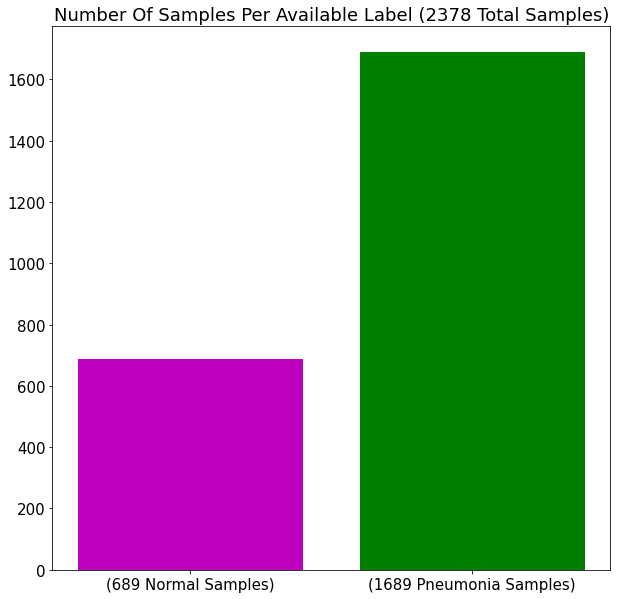

In [6]:
# Plot a bar with numbers of normal and pneumonia diagnoses
plt.bar([1, 2], height=[len(labels_norm), len(labels_pn)], 
        tick_label=['({0:d} Normal Samples)'.format(len(labels_norm)), 
                    '({0:d} Pneumonia Samples)'.format(len(labels_pn))], 
        color=['m', 'g'])

plt.title('Number Of Samples Per Available Label ({0:d} Total Samples)'.
          format(len(labels_norm) + len(labels_pn)))

plt.show()

Now, let's plot a couple of images from each diagnosis to see how they look like.

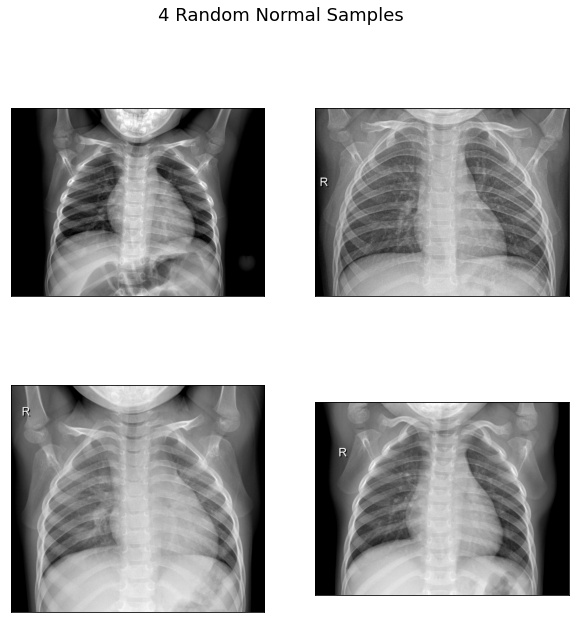

In [7]:
# Build a 2 x 2 figure
rows, columns = 2, 2
fig, axes = plt.subplots(rows, columns)

# Choose random indices for image selection
norm_indices = np.random.choice(len(image_paths_norm), rows * columns)
pn_indices = np.random.choice(len(image_paths_pn), rows * columns)

# Make a list with images to plot
imgs_to_plot_norm = [image_paths_norm[i] for i in norm_indices]
imgs_to_plot_pn = [image_paths_pn[i] for i in pn_indices]

# Variable used for indending through the image list
current_index = 0

# Set figure title
fig.suptitle('4 Random Normal Samples')

# Plot normal images
for i in range(rows):
    for j in range(columns):
        img = load_img(imgs_to_plot_norm[current_index])        
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        current_index +=1
        
plt.show()

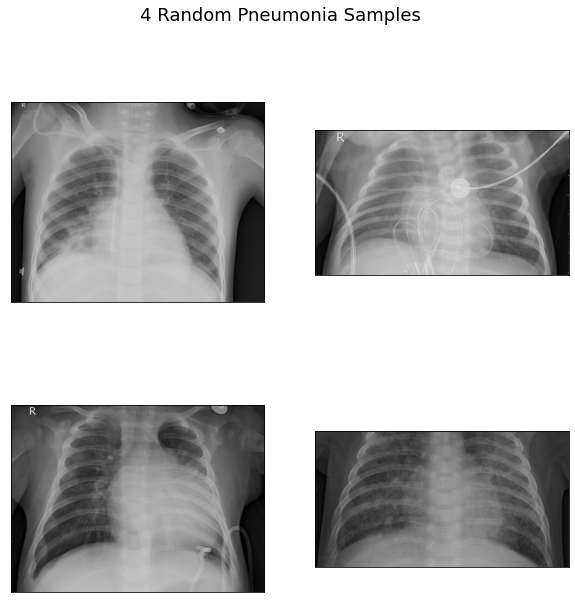

In [8]:
fig, axes = plt.subplots(rows, columns)

current_index = 0

# Set figure title
fig.suptitle('4 Random Pneumonia Samples')

# Plot pneumonia images
for i in range(rows):
    for j in range(columns):
        img = load_img(imgs_to_plot_pn[current_index])        
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        current_index +=1
        
plt.show()

Generally, pneumonia manifests itself in alveoli consolidations mainly caused by bacteria and fluid. The differences between healthy and pneumonia X-Rays are pretty clearly visible, though in some images, the differences may not be as definite. 

As our next step, we will divive our image paths and labels into training, validation, and test sets. The purpose of these sets is as follows:
1. **Training data** will be used to update the weights of the network to achieve high performance.
2. **Validation data** will be used to tweak model hyperparameters to achieve low loss, high accuracy, and no overfitting.
3. **Test data** will be used for final performance validation and to make sure that the model doesn't overfit to the parameters we choose based on validation performance.

Note that I am not using the splits proposed by the original publisher of the data - this is because I have been unable to achieve high performance with it. Maybe it's possible, but I decided not to waste time and split the data anew myself.

For splitting, I am using scikit-learn's train_test_split method. Since this method only divides the dataset into training and test sets, I've then further divided the test set into validation and test sets - the former and latter halves of the initial test set respectively. The data distribution is 70% training and 15% validation & test data.

In [9]:
from sklearn.model_selection import train_test_split

# Divide the image path & label arrays into train & test sets. This is done without loading images to save memory
X_train_dir, X_test_dir, y_train, y_test = \
                                           train_test_split(image_paths, labels, test_size=0.3)

# Divide the test set into validation (for use during training) and test (for post-training evaulation) sets
X_val_dir, y_val = X_test_dir[:len(X_test_dir) // 2], \
                   y_test[:len(y_test) // 2]

X_test_dir, y_test = X_test_dir[len(X_test_dir) // 2:], \
                     y_test[len(y_test) // 2:]

I will be feeding the data into the model via an *ImageDataGenerator* object. However, because we have image paths rather than image arrays, we can't use the *flow* method. Instead, we have to use the *flow_from_dataframe* method, which requires DataFrames containing image paths under the "filename" column and labels under the "class" column.

Below, we create DataFrames for each of our sets.

In [10]:
# Create DataFrames for the image generator
train_df = pd.DataFrame(np.transpose([X_train_dir, y_train]), 
                        columns=['filename', 'class'])

val_df = pd.DataFrame(np.transpose([X_val_dir, y_val]), 
                      columns=['filename', 'class'])

test_df = pd.DataFrame(np.transpose([X_test_dir, y_test]), 
                       columns=['filename', 'class'])

In [11]:
print(test_df)

                                              filename      class
0    ../../chest_xray/D1/test/PNEUMONIA/person161_b...  Pneumonia
1    ../../chest_xray/D1/train/PNEUMONIA/person438_...  Pneumonia
2    ../../chest_xray/D1/train/PNEUMONIA/person27_b...  Pneumonia
3    ../../chest_xray/D1/train/PNEUMONIA/person59_b...  Pneumonia
4    ../../chest_xray/D1/train/PNEUMONIA/person267_...  Pneumonia
..                                                 ...        ...
352  ../../chest_xray/D1/train/PNEUMONIA/person19_b...  Pneumonia
353  ../../chest_xray/D1/train/NORMAL/IM-0539-0001-...     Normal
354  ../../chest_xray/D1/train/PNEUMONIA/person444_...  Pneumonia
355  ../../chest_xray/D1/train/PNEUMONIA/person82_v...  Pneumonia
356  ../../chest_xray/D1/train/NORMAL/IM-0575-0001....     Normal

[357 rows x 2 columns]


Next, we declare ImageDataGenerator objects for batch input along with data augmentation to reduce overfitting. Data augmentation is only done on the training data (via the *datagen* object) - as for the validation and test data, only scaling to [0, 1] was performed (via the *test_datagen* object).

For data augmentation, I picked parameters so that the output images would be realistic and similar to what the model would be seeing in real-world use.

After declaring generator objects, I declare *DataFrameIterator* objects via the *flow_from_dataframe* method. I passed arguments for: 
1. Target image size (512 x 512). 
2. Color mode (grayscale).
3. Batch size (64).
4. Class mode (binary).
5. Shuffling (*True* for training data and *False* for validation & test data).

When called, the *DataFrameIterator* will read images from the provided filenames, resize them, convert string labels to binary ("Pneumonia" to 1 and "Normal" to 0), and return 64 image-label pairs.

In [12]:
# Set the batch size for the generator and training
BATCH_SIZE = 64

# Declare an image generator for image augmentation
datagen = ImageDataGenerator(rescale = 1./255,
                             zoom_range=0.1, 
                             height_shift_range=0.05, 
                             width_shift_range=0.05,
                             rotation_range=5)


# Declare an image generator for validation & testing without generation
test_datagen = ImageDataGenerator(rescale = 1./255)

# Declare generators for training, validation, and testing from DataFrames
train_gen = datagen.flow_from_dataframe(train_df,
                                        target_size=(512, 512),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=True)

val_gen = test_datagen.flow_from_dataframe(val_df,
                                        target_size=(512, 512),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=False)

test_gen = test_datagen.flow_from_dataframe(test_df,
                                        target_size=(512, 512),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=False)

Found 1664 validated image filenames belonging to 2 classes.
Found 357 validated image filenames belonging to 2 classes.
Found 357 validated image filenames belonging to 2 classes.


In [29]:
images, labels = next(test_datagen.flow_from_directory('../../chest_xray/D1/train'))
# 顯示資料 type 和 shape
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

Found 1738 images belonging to 2 classes.
float32 (32, 256, 256, 3)
float32 (32, 2)


In [ ]:
print(images)

In [ ]:
print(labels)

For a little added input pipeline efficiency, I've also created *tf.Dataset* objects. I wanted to make use of the *prefetch* method of the *tf.Dataset* class to accelerate training a little. 

Image reading from the disk is a huge bottleneck for the model, and although my approach isn't the best one, it accelerates each epoch by about 20-30 seconds.

In [32]:
# Declare TensorFlow Datasets for more efficient training
train_data = tf.data.Dataset.from_generator(lambda: train_gen,
                                            output_types=(tf.float32, tf.int32),
                                            output_shapes=([None, 512, 512, 1], [None, 2]))

val_data = tf.data.Dataset.from_generator(lambda: val_gen,
                                          output_types=(tf.float32, tf.int32),
                                          output_shapes=([None, 512, 512, 1], [None, 2]))

test_data = tf.data.Dataset.from_generator(lambda: test_gen,
                                           output_types=(tf.float32, tf.int32),
                                           output_shapes=([None, 512, 512, 1], [None, 2]))

Now, let's see how our training generator works in terms of data augmentation. Let's load a couple of images from the disk, pass them to the *flow* method of the generator (this method acccepts image arrays), and plot the base and augmented images in RGB.

As you'll see, the augmented images look pretty decently and are realistic enough for training.

In [33]:
images_to_augment = []

for image_path in image_paths[:4]:
    image = load_img(image_path, target_size=(512, 512))
    image = img_to_array(image)
    images_to_augment.append(image)
    
images_to_augment = np.array(images_to_augment)

images_augmented = next(datagen.flow(x=images_to_augment,
                                batch_size=10,
                                shuffle=False))

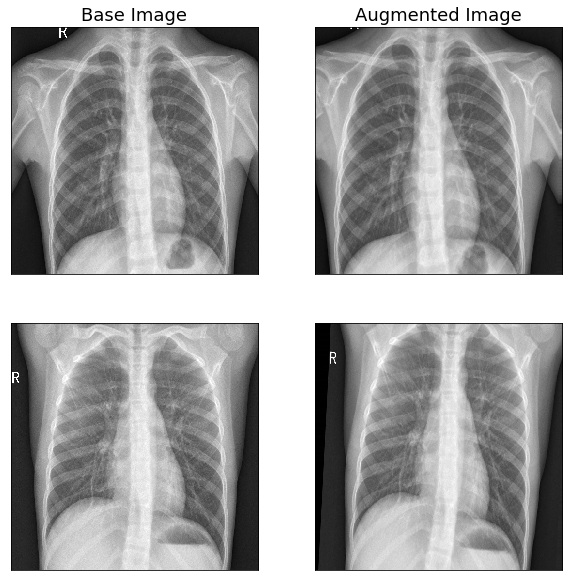

In [34]:
from tensorflow.keras.preprocessing.image import array_to_img

fig, axes = plt.subplots(2, 2)

for i in range(2):
    axes[i, 0].imshow(array_to_img(images_to_augment[i]), 
                      interpolation='nearest')
    
    axes[i, 1].imshow(array_to_img(images_augmented[i]), 
                      interpolation='nearest')
    
    axes[i, 0].set_xticks([])
    axes[i, 1].set_xticks([])
    
    axes[i, 0].set_yticks([])
    axes[i, 1].set_yticks([])
    
columns = ['Base Image', 'Augmented Image']
for ax, column in zip(axes[0], columns):
    ax.set_title(column) 
    
plt.show()

And below is how I used the *prefetch* method of the *tf.Dataset* class that I talked about.

In [35]:
def feed_data(dataset):
    """Feed data to a model with prefetching
    
    Arguments:
        dataset (tf.Dataset): A dataset that to be fed to the model
        
    Returns:
        dataset (tf.Dataset): A prefetched dataset
    """
    
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  
    
    return dataset

Finally, we've reached model creation. The model architecture that you see below is the final architecture that I chose after some testing. I've saved the results of my test runs in csv files, and we'll be plotting them later so that you see how my model selection went.

Now, let's define the model and then plot its summary along with the model architecture.

In [36]:
# Define the CNN Keras model
def create_model():
    """
    Create a model
    
    Returns:
        model (tf.keras.Model): An instance of Model
    """
    
    # Model input
    input_layer = layers.Input(shape=(512, 512, 1), name='input')    

    # First block
    x = layers.Conv2D(filters=64, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_1')(input_layer)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_1')(x)
    x = layers.Dropout(0.1, name='dropout_1')(x)
    
    # Second block
    x = layers.Conv2D(filters=96, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_2')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_2')(x)
    x = layers.Dropout(0.1, name='dropout_2')(x)

    # Third block
    x = layers.Conv2D(filters=128, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_3')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_3')(x)
    x = layers.Dropout(0.1, name='dropout_3')(x)
    
    # Fourth block
    x = layers.Conv2D(filters=160, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_4')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_4')(x)
    x = layers.Dropout(0.1, name='dropout_4')(x)

    # Fifth block
    x = layers.Conv2D(filters=192, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_5')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_5')(x)
    x = layers.Dropout(0.1, name='dropout_5')(x)
    
    # Sixth block
    x = layers.Conv2D(filters=224, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_6')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_6')(x)
    x = layers.Dropout(0.1, name='dropout_6')(x)
    
    # Seventh block
    x = layers.Conv2D(filters=256, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_7')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_7')(x)
    x = layers.Dropout(0.1, name='dropout_7')(x)

    # Pooling and output
    x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)    
    output = layers.Dense(units=2, 
                          activation='softmax', 
                          name='output')(x)

    # Model creation and compilation
    
    model = Model (input_layer, output)    
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [37]:
# Create a Model object
model = create_model()

In [38]:
# See the layer and parameter summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 512, 512, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 64)      640       
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 dropout_1 (Dropout)         (None, 256, 256, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 96)      55392     
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 128, 128, 96)      0         
                                                                 
 dropout_2 (Dropout)         (None, 128, 128, 96)      0   

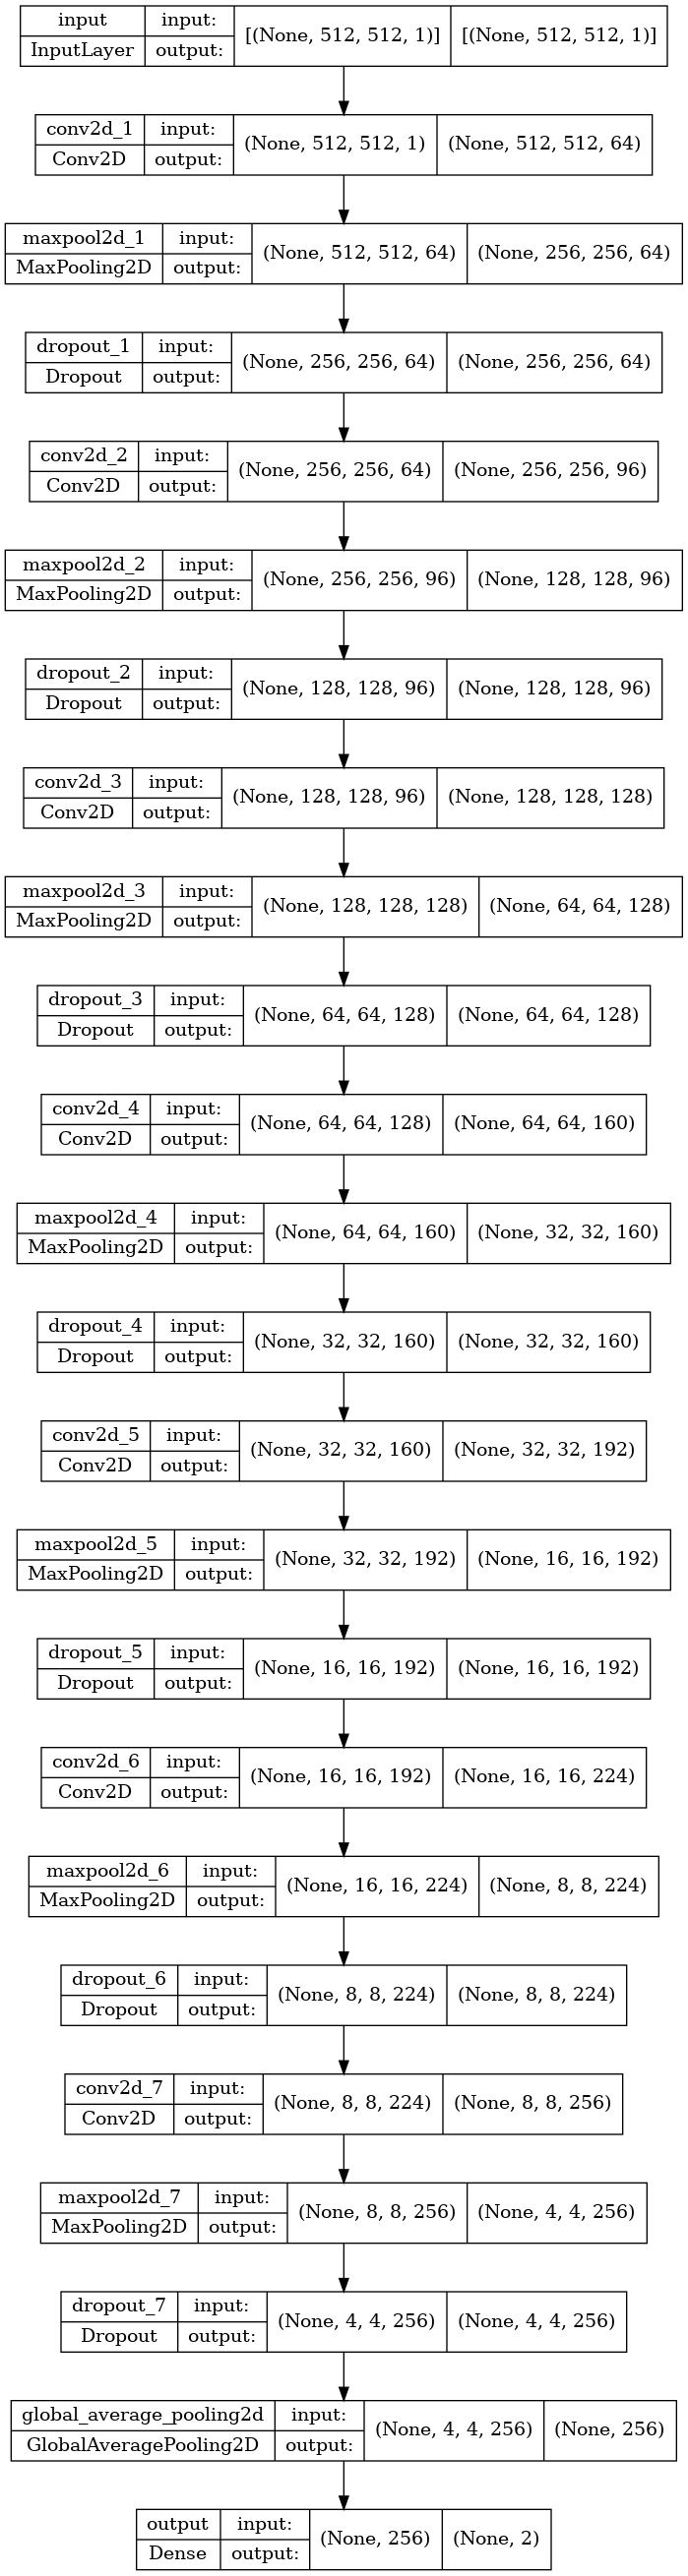

In [39]:
from tensorflow.keras.utils import plot_model

# See graphical representation of the model
plot_model(model, show_shapes=True)

Another method that I've used to optimize model performance was learning rate decay. I've used exponential decay since it seemed the most promising - however, other decay schedules may show better performance.

The *lr_decay* method is to be given to Keras' *LearningRateScheduler* object and then provided to the model as a callback. 

In [40]:
# Set up exponential learning rate decay
def lr_decay(epoch):
    """
    Create a learning rate reduction scheduler
    
    Arguments:
        epoch (int): The index of the current epoch        
        
    Returns:
        lr (float): Learning rate as of epoch
    """
    
    initial_lr = 0.001    
    lr = initial_lr * np.exp(-0.1 * epoch)
    return lr

Below, I create three callbacks for training - the aforementioned *LearningRateScheduler*, a *CSVLogger* object for model result saving, and a *ModelCheckpoint* object for model weight saving after each epoch. I did the last two to save results and models since I did my analysis in multiple notebook runs.

Here, I am declaring the *CSVLogger* and *ModelCheckpoint* for demonstration - we won't be using them since I've already done the training & testing.

In [41]:
# Import classes for metric saving, model saving, and LR reduction
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler

lr_scheduler = LearningRateScheduler(lr_decay, 1)
csv_logger = CSVLogger(filename='7-layer_double_adam_512_aug_bn_dropout01_explr_D1.csv')
model_checkpoint = ModelCheckpoint(filepath='7-layer_double_adam_512_aug_bn_dropout01_explr_{epoch:04d}_D1.hdf5')

Next, we need to define the number of training and validation steps. I've calculated them by diving sample number by batch size and then rounding the result down. Since the result is rounded down, not all images will be fed into the model. I did this consciously since I've also tested models without data augmentation - without data augmentation, I might have been providing duplicate images to the model, which I wanted to avoid.

In [42]:
# Calculate the number of steps for training and validation
train_steps = train_gen.samples // BATCH_SIZE
val_steps = val_gen.samples // BATCH_SIZE

Below, I commence training will validation data and callbacks. I've commented this part out because training takes a long time and because I have the results anyway.

In [43]:

history = model.fit(feed_data(train_data),                    
                    epochs=10,                    
                    steps_per_epoch=train_steps,                    
                    validation_data=(feed_data(val_data)),
                    validation_steps=val_steps,                    
                    shuffle=False,
                    callbacks=[lr_scheduler, csv_logger, model_checkpoint])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
26/26 [==============================] - 52s 2s/step - loss: 0.6373 - accuracy: 0.6971 - val_loss: 0.6102 - val_accuracy: 0.7250 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009048374180359595.
Epoch 2/10
26/26 [==============================] - 43s 2s/step - loss: 0.6061 - accuracy: 0.7127 - val_loss: 0.6151 - val_accuracy: 0.7250 - lr: 9.0484e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008187307530779819.
Epoch 3/10
26/26 [==============================] - 43s 2s/step - loss: 0.5402 - accuracy: 0.7127 - val_loss: 0.5544 - val_accuracy: 0.7250 - lr: 8.1873e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007408182206817179.
Epoch 4/10
26/26 [==============================] - 43s 2s/step - loss: 0.4770 - accuracy: 0.7109 - val_loss: 0.3804 - val_accuracy: 0.7250 - lr: 7.4082e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006703200460